In [1]:
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

from rashomon import tva
from rashomon import loss
from rashomon import counter
from rashomon import metrics
from rashomon import extract_pools
from rashomon.aggregate import RAggregate_profile, RAggregate
from rashomon.sets import RashomonSet, RashomonProblemCache, RashomonSubproblemCache


%load_ext autoreload
%autoreload 2
# %matplotlib inline

## Multiple profiles

In [2]:
# need a function to map policy indices to profiles

M = 2
R = np.array([5, 5])

num_profiles = 2**M
profiles, profile_map = tva.enumerate_profiles(M)

all_policies = tva.enumerate_policies(M, R)
num_policies = len(all_policies)

policy = (2, 2)
profile = tva.policy_to_profile(policy)
print(profile_map[profile])

3


### Generate data
Setup profiles

In [3]:
# Profile 0: (0, 0)
sigma_0 = None
mu_0 = np.array([0])

# Profile 1: (0, 1)
# Simulation #2
sigma_1 = np.array([[1, 1, 0]])
mu_1 = np.array([0.5, 3.8])
# Simulation #3
# sigma_1 = np.array([[1, 1, 0]])
# mu_1 = np.array([0, 3.5])

# Profile 2: (1, 0)
# Simulation #2
sigma_2 = np.array([[1, 1, 1]])
mu_2 = np.array([2])
# Simulation #3
# sigma_2 = np.array([[0, 0, 0]])
# mu_2 = np.array([3.2, 3.4, 3.3, 3.4])

# Profile 3: (1, 1)
## This one is Simulation #2
sigma_3 = np.array([[1, 1, 1],
                    [1, 1, 0]])
mu_3 = np.array([3, 4])
## This one is potentially Simulation #3
# sigma_3 = np.array([[1, 1, 1],
#                     [1, 1, 1]])
# mu_3 = np.array([2])#, 2, 2, 2])

sigma = [sigma_0, sigma_1, sigma_2, sigma_3]
mu = [mu_0, mu_1, mu_2, mu_3]
# simulation #2
# var = [1] * num_policies
var = [[1], [1, 1], [1], [1, 1]]
# Simulation #3
# var = [[1], [1, 1], [2, 2, 2, 2], [1, 1, 1, 1]]

policies_profiles = {}
policies_profiles_masked = {}
policies_ids_profiles = {}
pi_policies = {}
pi_pools = {}
for k, profile in enumerate(profiles):

    policies_temp = [(i, x) for i, x in enumerate(all_policies) if tva.policy_to_profile(x) == profile]
    unzipped_temp = list(zip(*policies_temp))
    policies_ids_k = list(unzipped_temp[0])
    policies_k = list(unzipped_temp[1])
    policies_profiles[k] = deepcopy(policies_k)
    policies_ids_profiles[k] = policies_ids_k

    
    profile_mask = list(map(bool, profile))

    # Mask the empty arms
    for idx, pol in enumerate(policies_k):
        policies_k[idx] = tuple([pol[i] for i in range(M) if profile_mask[i]])
    policies_profiles_masked[k] = policies_k

    if np.sum(profile) > 0:
        pi_pools_k, pi_policies_k = extract_pools.extract_pools(policies_k, sigma[k])
        if len(pi_pools_k.keys()) != mu[k].shape[0]:
            print(f"Profile {k}. Expected {len(pi_pools_k.keys())} pools. Received {mu[k].shape[0]} means.")
        pi_policies[k] = pi_policies_k
        pi_pools[k] = {}
        for x, y in pi_pools_k.items():
            y_full = [policies_profiles[k][i] for i in y]
            y_agg = [all_policies.index(i) for i in y_full]
            pi_pools[k][x] = y_agg
    else:
        pi_policies[k] = {0: 0}
        pi_pools[k] = {0: [0]}


In [4]:

best_per_profile = [np.max(mu_k) for mu_k in mu]
true_best_profile = np.argmax(best_per_profile)
true_best = pi_pools[true_best_profile][np.argmax(mu[true_best_profile])]

print(true_best)
for x in true_best:
    print(all_policies[x])

[9, 14, 19, 24]
(1, 4)
(2, 4)
(3, 4)
(4, 4)


In [8]:
# Random data

np.random.seed(3)

# mu = np.random.uniform(0, 4, size=num_pools)
# mu = np.array([3, 6, 1, 4])
# mu = [0] * num_policies
# var = [1] * num_policies

n_per_pol = 100

num_data = num_policies * n_per_pol
X = np.zeros(shape=(num_data, M))
D = np.zeros(shape=(num_data, 1), dtype='int_')
y = np.zeros(shape=(num_data, 1))

idx_ctr = 0
for k, profile in enumerate(profiles):
    policies_k = policies_profiles[k]

    for idx, policy in enumerate(policies_k):
        policy_idx = [i for i, x in enumerate(all_policies) if x == policy]
        
        profile_id = tva.policy_to_profile(policy)
        pool_id = pi_policies[k][idx]
        # pool_i = pi_policies[idx]
        mu_i = mu[k][pool_id]
        # var_i = var[policy_idx[0]]
        var_i = var[k][pool_id]
        y_i = np.random.normal(mu_i, var_i, size=(n_per_pol, 1))
    
        start_idx = idx_ctr * n_per_pol
        end_idx = (idx_ctr + 1) * n_per_pol
    
        X[start_idx:end_idx, ] = policy
        # D[start_idx:end_idx, ] = idx
        D[start_idx:end_idx, ] = policy_idx[0]
        y[start_idx:end_idx, ] = y_i
    
        idx_ctr += 1

policy_means = loss.compute_policy_means(D, y, num_policies)

G = tva.alpha_matrix(all_policies)
D_matrix = tva.get_dummy_matrix(D, G, num_policies)

In [56]:
# Simulation 2
R_set, rashomon_profiles = RAggregate(M, R, 10, D, y, 1.9, reg=1e-1)
# Simulation 3
# R_set, rashomon_profiles = RAggregate(M, R, 15, D, y, 2.5, reg=1e-1)

print(len(R_set))

113


In [57]:
best_profile_counter = np.zeros(shape=(num_profiles,))

reg = 1e-1
best_loss = np.inf
best_policy_o = None

for r_set in R_set:
    pi_policies_profiles_r = {}
    
    for k, profile in enumerate(profiles):
        _, pi_policies_r_k = extract_pools.extract_pools(
            policies_profiles_masked[k],
            rashomon_profiles[k].sigma[r_set[k]]
        )
        pi_policies_profiles_r[k] = pi_policies_r_k
    
    pi_pools_r, pi_policies_r = extract_pools.aggregate_pools(pi_policies_profiles_r, policies_ids_profiles)
    pool_means_r = loss.compute_pool_means(policy_means, pi_pools_r)
    y_pred = metrics.make_predictions(D, pi_policies_r, pool_means_r)

    this_loss = mean_squared_error(y, y_pred) + reg * len(pi_pools_r)
    
    best_pools = np.argwhere(pool_means_r == np.max(pool_means_r))[0]

    for best_pool in best_pools:
        best_policy_id = pi_pools_r[best_pool][0]
        best_policy = all_policies[best_policy_id]
        best_profile = tva.policy_to_profile(best_policy)
        profile_id = profile_map[best_profile]

        best_profile_counter[profile_id] += 1
        
        if this_loss < best_loss:
            best_loss = this_loss
            best_policy_o = best_policy
            print(len(pi_pools_r))

best_profile_freq = best_profile_counter / np.sum(best_profile_counter)

print(f"Best model loss {best_loss} and best policy {best_policy_o}")

6
Best model loss 1.6030934602664904 and best policy (1, 4)


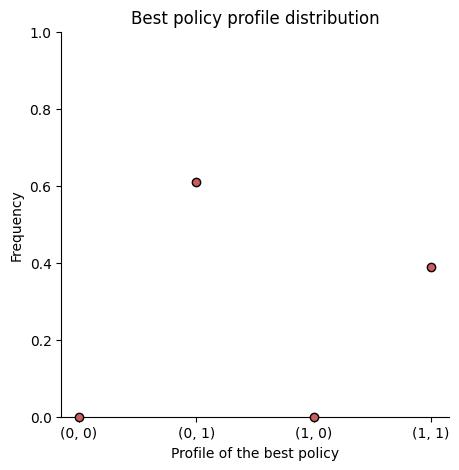

In [53]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

ax.scatter(np.arange(len(profiles)), best_profile_freq,
           color="indianred", edgecolor="black", zorder=3, clip_on=False,
           # label="Rashomon Set"
          )

ax.set_title("Best policy profile distribution")
ax.set_xticks(np.arange(len(profiles)), profiles)
ax.set_xlabel("Profile of the best policy")
ax.set_ylim(0, 1)
ax.set_ylabel("Frequency")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# plt.savefig("../Figures/worst_case/MSE.png", dpi=300, bbox_inches="tight")
plt.show()

## Single profile

In [34]:
sigma = np.array([[1, 1, 0],
                  [0, 1, 1],
                  [1, 0, 1]], dtype='float64')

M, n = sigma.shape
R = np.array([5, 5, 5])
profile = (1, 1, 1)

num_policies = np.prod(R-1)
profiles, profile_map = tva.enumerate_profiles(M)
all_policies = tva.enumerate_policies(M, R)
policies = [x for x in all_policies if tva.policy_to_profile(x) == profile]
pi_pools, pi_policies = extract_pools.extract_pools(policies, sigma)

for pool_id, pool in pi_pools.items():
    print(pool_id, ":", [policies[i] for i in pool])

0 : [(1, 1, 1), (1, 1, 2), (2, 1, 1), (2, 1, 2), (3, 1, 1), (3, 1, 2)]
1 : [(1, 1, 3), (1, 1, 4), (2, 1, 3), (2, 1, 4), (3, 1, 3), (3, 1, 4)]
2 : [(1, 2, 1), (1, 2, 2), (1, 3, 1), (1, 3, 2), (1, 4, 1), (1, 4, 2), (2, 2, 1), (2, 2, 2), (2, 3, 1), (2, 3, 2), (2, 4, 1), (2, 4, 2), (3, 2, 1), (3, 2, 2), (3, 3, 1), (3, 3, 2), (3, 4, 1), (3, 4, 2)]
3 : [(1, 2, 3), (1, 2, 4), (1, 3, 3), (1, 3, 4), (1, 4, 3), (1, 4, 4), (2, 2, 3), (2, 2, 4), (2, 3, 3), (2, 3, 4), (2, 4, 3), (2, 4, 4), (3, 2, 3), (3, 2, 4), (3, 3, 3), (3, 3, 4), (3, 4, 3), (3, 4, 4)]
4 : [(4, 1, 1), (4, 1, 2)]
5 : [(4, 1, 3), (4, 1, 4)]
6 : [(4, 2, 1), (4, 2, 2), (4, 3, 1), (4, 3, 2), (4, 4, 1), (4, 4, 2)]
7 : [(4, 2, 3), (4, 2, 4), (4, 3, 3), (4, 3, 4), (4, 4, 3), (4, 4, 4)]


### Generate data

In [30]:
np.random.seed(3)

num_pools = len(pi_pools)
# mu = np.random.uniform(0, 4, size=num_pools)
# mu = np.array([3, 6, 1, 4])
mu = np.array([3, 4, 6, 5, 1, 0, 3, 2])
var = [1] * num_pools

n_per_pol = 10

num_data = num_policies * n_per_pol
X = np.ndarray(shape=(num_data, M))
D = np.ndarray(shape=(num_data, 1), dtype='int_')
y = np.ndarray(shape=(num_data, 1))

for idx, policy in enumerate(policies):
    pool_i = pi_policies[idx]
    mu_i = mu[pool_i]
    var_i = var[pool_i]
    y_i = np.random.normal(mu_i, var_i, size=(n_per_pol, 1))

    start_idx = idx * n_per_pol
    end_idx = (idx + 1) * n_per_pol

    X[start_idx:end_idx, ] = policy
    D[start_idx:end_idx, ] = idx
    y[start_idx:end_idx, ] = y_i
    

In [31]:
# This function needs to called only once
policy_means = loss.compute_policy_means(D, y, num_policies)

# This function needs to be called every time the pools change
mu_pools = loss.compute_pool_means(policy_means, pi_pools)

# This function needs to be called every time the pools change
Q = loss.compute_Q(D, y, sigma, policies, policy_means, 0.1)

print(Q)

1.8126958244093103


In [32]:
i = 0
j = 0

B = loss.compute_B(D, y, sigma, i, j, policies, policy_means, 0.1)
print(B)

1.7862060864721792


### RAggregate

In [33]:
P_set = RAggregate(M, R, 10, D, y, 2, reg=0.1)
print(P_set.size)
P_set.seen(sigma)

7


True

In [58]:
pol_means = loss.compute_policy_means(D, y, num_policies)
true_best = pi_pools[np.argmax(mu)]
min_dosage_best_policy = find_min_dosage(true_best, policies)

for s_i in P_set:
    # print(s_i)
    pi_pools_i, pi_policies_i = extract_pools.extract_pools(policies, s_i)
    pool_means_i = loss.compute_pool_means(pol_means, pi_pools_i)
    
    Q = loss.compute_Q(D, y, s_i, policies, pol_means, reg=0.1)
    y_pred = loss.make_predictions(D, pi_policies_i, pool_means_i)
    sqrd_err = mean_squared_error(y, y_pred)
    pol_max = loss.find_best_policies(D, y_pred)
    iou = loss.intersect_over_union(set(true_best), set(pol_max))

    # Min dosage membership
    min_dosage_present = check_membership(min_dosage_best_policy, pol_max)

    # Best policy difference
    best_pol_diff = np.max(mu) - np.max(pool_means_i)
    
    # print(np.max(y_pred), pool_means)
    print(f"Num pools: {len(pi_pools_i)}, Squared loss: {sqrd_err:0.5f}, Q: {Q:0.5f}")
    print(f"Best policy IOU: {iou:.3f}")
    print(f"Min dosage: {min_dosage_present}")
    print(f"Best policy error: {best_pol_diff}")
    print("---")

Num pools: 4, Squared loss: 1.30029, Q: 1.70029
Best policy IOU: 0.500
Min dosage: True
Best policy error: 0.4471226717855128
---
Num pools: 6, Squared loss: 1.29973, Q: 1.89973
Best policy IOU: 0.400
Min dosage: True
Best policy error: 0.4251355538334627
---
Num pools: 6, Squared loss: 1.29852, Q: 1.89852
Best policy IOU: 0.400
Min dosage: False
Best policy error: 0.40918740978712886
---
Num pools: 6, Squared loss: 1.29790, Q: 1.89790
Best policy IOU: 0.250
Min dosage: True
Best policy error: 0.43686580234869066
---
Num pools: 8, Squared loss: 1.01270, Q: 1.81270
Best policy IOU: 1.000
Min dosage: True
Best policy error: -0.09651153607163465
---
Num pools: 6, Squared loss: 1.29657, Q: 1.89657
Best policy IOU: 0.400
Min dosage: True
Best policy error: 0.398387635947028
---
Num pools: 8, Squared loss: 1.18809, Q: 1.98809
Best policy IOU: 0.667
Min dosage: True
Best policy error: 0.2681464021581057
---


### LASSO - Beta -> alpha

In [331]:
G = tva.alpha_matrix(all_policies)
# print(G)
D_matrix = tva.get_dummy_matrix(D, G, num_policies)

In [333]:
D_matrix.shape

(2500, 25)

In [398]:
reg_param = 1e-2
mod1 = linear_model.Lasso(reg_param, fit_intercept=False)
mod1.fit(D_matrix, y)
alpha_est = mod1.coef_
y_tva = mod1.predict(D_matrix)
sqrd_err = mean_squared_error(y_tva, y)
print(sqrd_err)
L1_tva = sqrd_err + reg_param * np.linalg.norm(alpha_est, ord=1)
Q_tva = sqrd_err + reg_param * np.linalg.norm(alpha_est, ord=0)
print(Q_tva, L1_tva)

1.4840692542164038
1.604069254216404 1.595105795973953


In [399]:
# print(pi_pools[1])
# np.unique(D[np.where(y_tva == np.max(y_tva)), ])
tva_best = metrics.find_best_policies(D, y_tva)
# iou_tva = metrics.intersect_over_union(set(true_best), set(tva_best))
# print(iou_tva)
# min_dosage_present_tva = metrics.check_membership(min_dosage_best_policy, pol_max)
# print(min_dosage_present_tva)
# best_policy_error_tva = np.max(mu) - np.max(y_tva)
# print(best_policy_error_tva)

In [400]:
for id in tva_best:
    print(all_policies[id])

(0, 4)


In [401]:
np.unique(y_tva)

array([-0.77848467, -0.07962758,  0.        ,  0.05476102,  0.08093156,
        1.13358496,  1.13932525,  1.1619113 ,  1.19391873,  1.19965902,
        1.8162336 ,  1.84824103,  1.85398132,  3.23057946,  3.30493164,
        3.31227524])

In [53]:
print(pi_pools[3])
np.unique(D[np.where(y_tva == np.unique(y_tva)[2]), ])

[52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


array([52, 56, 60])

### Varying R

In [192]:
# Idea: np.inf for arbitrary dosage?
sigma = np.array([[1, 0, 1],
                  [0, 1, np.inf]], dtype='float64')
# sigma = np.array([[0, 0, 0],
#                   [0, 0, np.inf]], dtype='float64')

M, n = sigma.shape
R = np.array([5, 4])

num_policies = np.prod(R-1)
policies = enumerate_policies(M, R)
pi_pools, pi_policies = extract_pools.extract_pools(policies, sigma)

for pool_id, pool in pi_pools.items():
    print(pool_id, ":", [policies[i] for i in pool])

0 : [(1, 1), (2, 1)]
1 : [(1, 2), (1, 3), (2, 2), (2, 3)]
2 : [(3, 1), (4, 1)]
3 : [(3, 2), (3, 3), (4, 2), (4, 3)]


In [193]:
counter.num_pools(sigma)

4.0

In [194]:
counter.num_admissible_poolings(4, M, R)

6

In [195]:
np.random.seed(3)

num_pools = len(pi_pools)
mu = np.random.uniform(0, 4, size=num_pools)
var = [1] * num_pools

n_per_pol = 10

num_data = num_policies * n_per_pol
X = np.ndarray(shape=(num_data, M))
D = np.ndarray(shape=(num_data, 1), dtype='int_')
y = np.ndarray(shape=(num_data, 1))

for idx, policy in enumerate(policies):
    pool_i = pi_policies[idx]
    mu_i = mu[pool_i]
    var_i = var[pool_i]
    y_i = np.random.normal(mu_i, var_i, size=(n_per_pol, 1))

    start_idx = idx * n_per_pol
    end_idx = (idx + 1) * n_per_pol

    X[start_idx:end_idx, ] = policy
    D[start_idx:end_idx, ] = idx
    y[start_idx:end_idx, ] = y_i

In [196]:
policy_means = loss.compute_policy_means(D, y, num_policies)
policy_means

array([[22.3306393 , 10.        ],
       [26.09289987, 10.        ],
       [26.9056259 , 10.        ],
       [14.77744099, 10.        ],
       [27.87404021, 10.        ],
       [29.12185777, 10.        ],
       [14.06728243, 10.        ],
       [21.12531734, 10.        ],
       [15.25551251, 10.        ],
       [12.69909817, 10.        ],
       [21.11531527, 10.        ],
       [19.32885624, 10.        ]])

In [197]:
Q = loss.compute_Q(D, y, sigma, policies, policy_means, reg=1)
Q

4.9889861406550375

In [198]:
i = 1
j = 1
B = loss.compute_B(D, y, sigma, i, j, policies, policy_means, reg=1)
print(B)

6.975889428946971


In [199]:
P_set = RAggregate(2, R, 4, D, y, 1.4, reg=0.1)
print(P_set.size)
P_set.seen(sigma)

5


True